In [157]:
import sys
sys.path.append("/auto/homes/fav25/jax/")

import jax.numpy as np
# import autograd.numpy
# import numpy as np

from SC_IPFP.sde_solvers import solve_sde_RK
from SC_IPFP.utils import log_kde_pdf_per_point, silvermans_rule

from jax.config import config
from jax import jit, grad, random
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import Dense, Relu, LogSoftmax, Sigmoid, Tanh
import numpy.random as npr
import jax
from tqdm.notebook import tqdm
import numpy as onp


import itertools
from functools import partial
# np = jax.numpy
import matplotlib.pyplot as plt
# np = autograd.numpy

In [278]:

def knn_log_prob(xTrain, xTest, k=5):
    """
    Finds the k nearest neighbors of xTest in xTrain.
    Input:
    xTrain = n x d matrix. n=rows and d=features
    xTest = m x d matrix. m=rows and d=features (same amount of features as xTrain)
    k = number of nearest neighbors to be found
    Output:
    dists = distances between xTrain/xTest points. Size of n x m
    indices = kxm matrix with indices of yTrain labels
    """
    #the following formula calculates the Euclidean distances.
    distances = -2 * np.dot(xTrain, xTest.T) + np.sum(xTest**2,axis=1) + np.sum(xTrain**2,axis=1)[:, np.newaxis]
    #because of numpy precision, some really small numbers might 
    #become negatives. So, the following is required.
    distances = np.clip(distances, 0, None)
    #for speed you can avoid the square root since it won't affect
    #the result, but apply it for exact distances.
#     distances = distances**.5
#     indices = np.argsort(distances, 0) #get indices of sorted items
    distances = np.sort(distances,0) #distances sorted in axis 0
    #returning the top-k closest distances.
    return  -np.mean(distances[:10,:])**.5


In [283]:
class cIPFP(object):
    
    def __init__(self, X_0, X_1, weights=[100], batch_size=None,  rng = jax.random.PRNGKey(0), 
                nrng = npr.RandomState(0), number_time_steps=16, sde_solver=solve_sde_RK, sigma_sq=1, 
                step_size = 0.001, num_epochs = 10, momentum_mass = 0.9, create_network=None, log_prob=log_kde_pdf_per_point):
        
        self.sde_solver = sde_solver
        
        self.number_time_steps = number_time_steps
        self.dt = 1.0 / number_time_steps
        
        
        self.batch_size_f = X_0.shape[0] if batch_size is None else batch_size
        self.batch_size_b = X_1.shape[0] if batch_size is None else batch_size
        
        
        self.X_0 = X_0
        self.X_1 = X_1
        
        self.H_0 = silvermans_rule(X_0)
        self.H_1 = silvermans_rule(X_1)
        
        _, self.dim = self.X_0.shape
        
        create_net = self.create_network if  create_network is None else create_network
        
        self.b_forward_init, self.b_forward = create_net(
            self.dim, weights
        )
        self.b_backward_init, self.b_backward = create_net(
            self.dim, weights
        )
        
        self.sigma = (lambda X,t: sigma_sq)
        
        self.rng = rng
        self.nrng = nrng
        
        self.opt_init_f, self.opt_update_f, self.get_params_f = (
            optimizers.adam(step_size) #, mass=momentum_mass)
        )
        
        self.opt_init_b, self.opt_update_b, self.get_params_b = (
            optimizers.adam(step_size) #, mass=momentum_mass)
        )
        
        num_complete_batches_f, leftover_f = divmod(self.X_0.shape[0], self.batch_size_f)
        self.num_batches_f = num_complete_batches_f + bool(leftover_f)
                                               
        num_complete_batches_b, leftover_b = divmod(self.X_1.shape[0], self.batch_size_b)
        self.num_batches_b = num_complete_batches_b + bool(leftover_b)
        
        self.theta_f = None
        self.theta_b = None
        
        self.log_prob=log_prob
        
    
    @staticmethod
    def create_network(dim, weights):
        
        model  = []
        for weight in weights:
            model.append(
                Dense(weight)
            )
                        
            model.append(
                Relu
            )
            
        
        model.append(Dense(dim))
    
        init_random_params, predict = stax.serial(
           *model
        )
        return init_random_params, predict
    
    def data_stream(self, forward=True):
        rng = self.nrng
        X = self.X_0 if forward else self.X_1
        
        batch_size = self.batch_size_f if forward else self.batch_size_b
        num_batches = self.num_batches_f if forward else self.num_batches_b
        
        num_train = self.X_0.shape[0] if forward else self.X_1.shape[0]
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield X[batch_idx] 
        
#     @partial(jit, static_argnums=(0,3))
    def loss_for_trajectory(self, Xt, theta, W, forwards):
        n_, *_ = Xt.shape
        
        if not forwards : Xt = Xt[: , ::-1, :]
        
        if forwards:
            b_minus  = self.b_backward(self.theta_b, Xt)
            b_plus = self.b_forward(theta, Xt)
        else:
            b_minus  = self.b_backward(theta, Xt)
            b_plus = self.b_forward(self.theta_f, Xt)

            
        delta_Xt = Xt[:, 1:, :] - Xt[:, :-1, :]  
        
        sign = 1.0 if forwards else -1.0
        
        ito_integral = sign *  (b_plus[:, :-1,:] - b_minus[:, 1:,:])  * delta_Xt
        
        time_integral = sign *  (b_plus**2 - b_minus**2) * self.dt 
        
        out =  ito_integral.sum(axis=(1,2)) - 0.5 * time_integral.sum(axis=(1,2))
        
        if np.isnan(out).any() or np.isinf(out).any():
            import pdb; pdb.set_trace()
        return out

#     @partial(jit, static_argnums=(0,6,7,8,9,10,11))
    def inner_loss_jit(self, theta, batch,  
                       batch_terminal_empirical,
                       H,  forwards):
        
        b = (
            self.b_forward if forwards else (lambda X, theta: -self.b_backward(X, theta))
        )
        
        t, Xt, *W = self.sde_solver(
            alfa=b, beta=self.sigma, dt=self.dt, X0=batch,
            N= self.number_time_steps, theta=theta
        )
        
        cross_entropy = -self.log_prob(Xt[:,-1,:], batch_terminal_empirical, H)
        main_term = self.loss_for_trajectory(Xt, theta, W, forwards)
        
        if np.isnan(cross_entropy).any() or np.isnan(main_term).any():
            import pdb; pdb.set_trace()

        J = np.mean(main_term + cross_entropy )
        J = np.squeeze(J)
        return J
    
    def inner_loss(self, theta, batch, forwards=True):
                       
        batch_terminal_empirical = next(self.data_stream(forward=not(forwards)))
    
        H = self.H_1 if forwards else self.H_0
        return self.inner_loss_jit(
            theta, batch,
            batch_terminal_empirical, H ,  forwards
        )

#     @partial(jit, static_argnums=(0,1, 4))
    def update(self, i, opt_state, batch, forwards=True):

        get_params = self.get_params_f if forwards else self.get_params_b
        params = get_params(opt_state)
        
        gradient = grad(self.inner_loss)(params, batch, forwards)
    
        opt_update  = self.opt_update_f if forwards else self.opt_update_b
        return opt_update(i, gradient, opt_state)

    def fit(self, IPFP_iterations=10, sub_iterations=10):     
        
        _, init_params_f = self.b_forward_init(self.rng, (-1, self.dim))                                             
        opt_state_f = self.opt_init_f(init_params_f)
        
        _, init_params_b = self.b_backward_init(self.rng, (-1, self.dim))                                               
        opt_state_b = self.opt_init_b(init_params_b)
        
        batches_f = self.data_stream(forward=True)
        batches_b = self.data_stream(forward=False)
        
        loss_f, loss_b = [], []
        
        self.theta_f = self.get_params_f(opt_state_f)
        self.theta_b = self.get_params_b(opt_state_b)
        
        for i in tqdm(range(IPFP_iterations)):

            itercount = itertools.count()

            for k in range(sub_iterations):
                for _ in range(self.num_batches_b):
                    batch_b =  next(batches_b)
                    opt_state_b  = self.update(
                        next(itercount), opt_state_b, batch_b, False
                    )

                params_b = self.get_params_b(opt_state_b)
                lossb = self.inner_loss(params_b, batch_b, False)
                print(f"loss b {lossb}")
            loss_b.append(lossb)

            self.theta_b = params_b

            itercount = itertools.count()

            for k in range(sub_iterations):
                for _ in range(self.num_batches_f):
                    batch_f =  next(batches_f)
                    opt_state_f = self.update(
                        next(itercount), opt_state_f, next(batches_f), True
                    )
                params_f = self.get_params_f(opt_state_f)
                lossf = self.inner_loss(params_f, batch_f, True)
                print(f"loss f {lossf}")
            loss_f.append(lossf)


            self.theta_f = params_f

            self.loss_f = loss_f
            self.loss_b = loss_b

        
        plt.plot(range(IPFP_iterations), loss_f, "g")
        plt.show()
        plt.plot(range(IPFP_iterations), loss_b, "b")
        plt.show()
    
    #     @partial(jit, static_argnums=(0,2))
    def transport_batch(self, batch_x, forwards):
        theta = self.theta_f if forwards else self.theta_b    
        b = self.b_forward if forwards else  lambda X, theta: -self.b_backward(X, theta)

        t, Xt = self.sde_solver(
            alfa=b, beta=self.sigma, dt=self.dt, 
            X0=batch_x.reshape(-1,self.dim), N=self.number_time_steps, theta=theta
        )

        return Xt[:,-1,:]
            

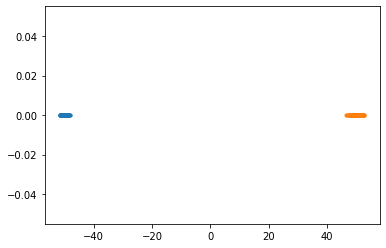

In [284]:
n = 900
n_2 = int(n / 3.0)

X1 = npr.randn(n).reshape(-1,1) +50
X21 = 0.6 * npr.randn(450).reshape(-1,1) + 50
X22 =  0.6 * npr.randn(450).reshape(-1,1) - 50
# X23 =  0.6 * npr.randn(300).reshape(-1,1) - 30

X2 = np.concatenate((X22, X21), axis=0)

perm = onp.random.permutation(n)

X2 = X2[perm,:] 

plt.plot(X2.flatten(), [0] * n, '.')
plt.plot(X1.flatten(), [0] * n, '.')

In [ ]:
c = cIPFP(X1, X2,  number_time_steps=100, batch_size=n , step_size = 0.01, weights=[100,100,100,100], log_prob=knn_log_prob)
c.fit(100,30)

loss b 171.43992614746094
loss b 696.106689453125
loss b 640.7555541992188
loss b 627.6548461914062
loss b 871.3699951171875
loss b 1009.4761352539062
loss b 1018.3032836914062
loss b 917.885009765625
loss b 982.6798706054688
loss b 969.7505493164062
loss b 920.9478759765625
loss b 983.1214599609375
loss b 1329.4444580078125
loss b 1573.5897216796875
loss b 1706.2254638671875
loss b 1676.153564453125
loss b 1512.8209228515625
loss b 1266.8414306640625
loss b 1053.77392578125
loss b 808.916015625
loss b 564.0643920898438
loss b 353.593994140625
loss b 535.6202392578125
loss b 814.0239868164062
loss b 1091.380615234375
loss b 1331.526123046875
loss b 1518.5772705078125
loss b 1651.553466796875
loss b 1707.4404296875
loss b 1704.2489013671875
loss f 267.824951171875
loss f 83.27066802978516
loss f 68.39569854736328
loss f 70.6180419921875
loss f 68.82461547851562
loss f 67.5814437866211
loss f 66.91957092285156
loss f 67.75393676757812
loss f 67.45069885253906
loss f 67.00446319580078
los

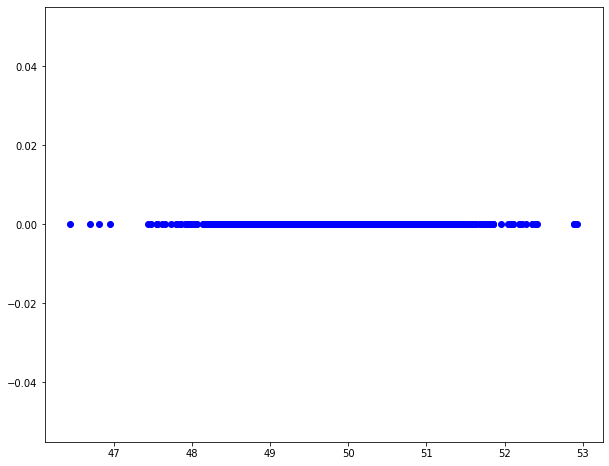

In [282]:
fig, axs = plt.subplots(1,  sharey=False, figsize=(10,8))


X = c.b_forward(c.theta_f, X1)
    
axs.plot(X.flatten(), [0] * n , 'ob', )

In [113]:
X.min(), X.max()

(DeviceArray(-25.244001, dtype=float32),
 DeviceArray(-25.240376, dtype=float32))

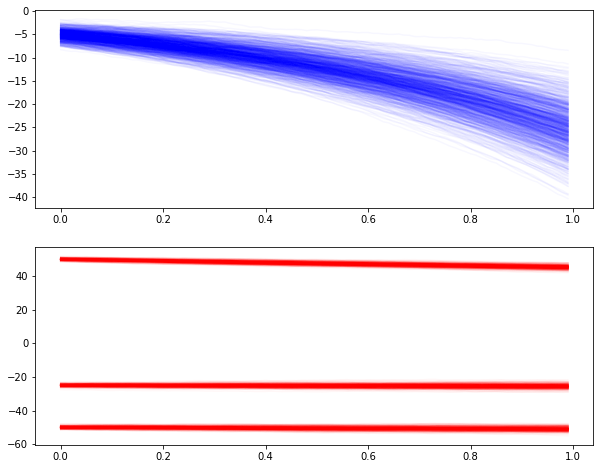

In [96]:
fig, axs = plt.subplots(2,1,  sharey=False, figsize=(10,8))


bb = lambda X, theta: -c.b_backward(X, theta)
t, Xts = c.sde_solver(X0=X1,dt=c.dt,  theta=c.theta_f,  beta=c.sigma, alfa=c.b_forward, N=c.number_time_steps)
for i in range(n):
    
    axs[0].plot(t.flatten(), Xts[i,...].flatten(), 'b', alpha=0.03, )
BXt = []   

t_, Xts_ = c.sde_solver(X0=X2, dt=c.dt,  theta=c.theta_b,  beta=c.sigma, alfa=bb, N=c.number_time_steps)
for i in range(n):
    
#     BXt.append(Xt_[-1,:])
    axs[1].plot(t_.flatten(), Xts_[i,...].flatten(), 'r', alpha=0.03)


In [49]:
X22 = np.array(c.transport_batch( X1, True)).flatten()

In [50]:
X11 = np.array(c.transport_batch(X2, False)).flatten()

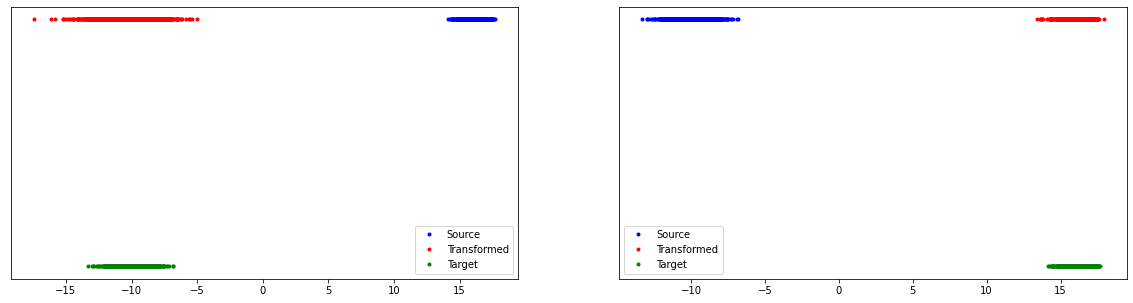

In [51]:
fig, axs = plt.subplots(1,2, figsize=(20,5))

axs[0].plot(X2.flatten(), [0] * n, 'b.', label="Source")
axs[0].plot(X11, [0] * n, 'r.', label="Transformed")
axs[0].plot(X1.flatten(), [-0.1] * n, 'g.', label="Target")
# axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].legend()

axs[1].plot(X1.flatten(), [0] * n, 'b.', label="Source")
axs[1].plot(X22, [0] * n, 'r.', label="Transformed")
axs[1].plot(X2.flatten(), [-0.1] * n, 'g.', label="Target")
# axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].legend()

In [163]:
batch_terminal_empirical_f = next(c.data_stream(forward=True))

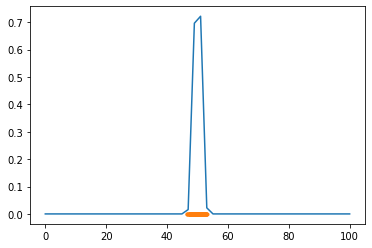

In [167]:
xx = np.linspace(0, 100).reshape(-1,1)

kd  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_f, c.H_0))
plt.plot(xx, kd)
plt.plot(batch_terminal_empirical_f , [0] * len(batch_terminal_empirical_f), ".")

In [165]:
batch_terminal_empirical_b = next(c.data_stream(False))

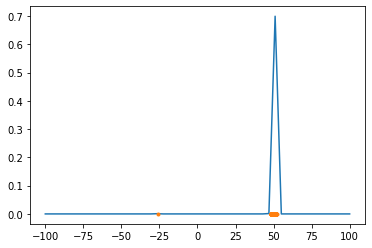

In [197]:
xx = np.linspace(-100, 100).reshape(-1,1)

kd_b  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_b, c.H_1))
plt.plot(xx, kd_b)
plt.plot(batch_terminal_empirical_b , [0] * len(batch_terminal_empirical_b), ".")

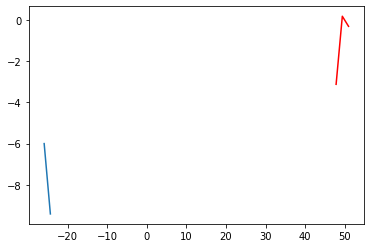

In [184]:
xx = np.linspace(-26, 51).reshape(-1,1)

kd_b  = (log_kde_pdf_per_point(xx, batch_terminal_empirical_b, c.H_1))
# plt.plot(xx, kd_b)
plt.plot(xx[0:2], kd_b[0:2])
plt.plot(xx[-3:], kd_b[-3:], "r")
# plt.plot(batch_terminal_empirical_b , [0] * len(batch_terminal_empirical_b), ".")

In [187]:
kd_b[-3:], np.exp(kd_b[-3:])

(DeviceArray([[-3.130105  ],
              [ 0.1694417 ],
              [-0.31907701]], dtype=float32), DeviceArray([[0.0437132],
              [1.1846433],
              [0.7268196]], dtype=float32))

In [188]:
kd_b[0:2], np.exp(kd_b[0:2])

(DeviceArray([[-6.0029383],
              [-9.411141 ]], dtype=float32), DeviceArray([[2.4714796e-03],
              [8.1807520e-05]], dtype=float32))